In [1]:
from data.soliton_dataset import SolitonDataset
from models.autoencoders import AutoencoderFC, AutoencoderConv1D, AutoencoderRNN
from utils.utils import train_val_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

/home/olegnest/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("df_soliton.csv")
df.head()

,1550.0,1549.8748798925087,1549.7497799834402,1549.624700267904,1549.4996407410108,1549.3746013978732,1549.2495822336057,1549.1245832433235,1548.999604422144,1548.8746457651862,...,1551.1269907041835,1551.0016885905482,1550.8764067194222,1550.751145085901,1550.6259036850813,1550.5006825120613,1550.375481561941,1550.2503008298215,1550.1251403108065,target
0,25.646056,25.650028,25.639966,25.615890,25.577855,25.525948,25.460286,25.381017,25.288318,25.182399,...,24.990649,25.116764,25.230041,25.330229,25.417107,25.490478,25.550179,25.596074,25.628057,cons_one
1,106.806266,112.409808,424.880242,686.914489,1405.909674,32.762638,130.044831,625.502883,1410.410023,115.495991,...,325.588571,138.500308,80.540597,225.456932,649.640334,1.996701,229.406224,761.822174,213.996442,cons_many
2,66.742776,523.683413,317.596944,1046.224701,744.272499,250.673772,426.875556,270.139851,449.280882,289.328584,...,81.704307,349.552649,420.345688,186.359228,363.575276,56.096868,331.010606,199.400477,114.965091,cons_many
3,17.406022,17.368336,17.246741,17.043367,16.761907,16.407466,15.986371,15.505929,14.974164,14.399550,...,14.380802,14.948072,15.474983,15.953217,16.374769,16.732200,17.018902,17.229347,17.359305,cons_one
4,103.739823,103.581529,102.286535,99.899522,96.525690,92.330496,87.533321,82.394103,77.191973,72.194477,...,67.858970,73.340071,78.891431,84.296851,89.358338,93.893959,97.737289,100.739222,102.772649,cons_one


In [4]:
float_columns = sorted(df.columns[:-1])
cols = ["target"]
for col in float_columns:
    if 1520 < float(col) < 1580:
        cols.append(col)
df = df[cols]

In [5]:
df_train, df_val, df_test = train_val_test_split(df, val_size=0.1, test_size=0.1, random_state=SEED)

In [6]:
dim_int = df_train.shape[1] - 1

model = AutoencoderFC(dim_code=dim_int)
# model = AutoencoderConv1D(1)
# model = AutoencoderRNN(dim_int, 1)

In [7]:
if model.__class__.__name__ == "AutoencoderRNN":
    batch_size = 1
else:
    batch_size = 32

scaler = None
# scaler = StandardScaler()

spectra_train = SolitonDataset(df_train, train=True, scaler=scaler)
spectra_val = SolitonDataset(df_val, scaler=scaler)
spectra_test = SolitonDataset(df_test, scaler=scaler)

train_dataloader = DataLoader(spectra_train,batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(spectra_val, batch_size=batch_size)
test_dataloader = DataLoader(spectra_test, batch_size=batch_size)

dataloaders = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader}

In [8]:
criterion = torch.nn.MSELoss()
triplet = torch.nn.TripletMarginLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

In [9]:
def get_hard_batch(emb, labels, device=torch.device("cpu")):
    distance_matrix = torch.cdist(emb, emb).to(device)
    mask = labels.unsqueeze(0) != labels.unsqueeze(1)
    mask = mask.to(device)
    negative = torch.argmin(mask * (mask * distance_matrix - 10), dim=1)

    mask = mask * 1 - 1
    mask.fill_diagonal_(0)
    positive = torch.argmax(mask * (-1) * distance_matrix, dim=1)

    return emb, emb[positive], emb[negative]

In [10]:
def train(model, dataloaders, optimizer, criterion, epochs=200, scheduler=None, batch_hard=False, device=torch.device("cpu")):

    model = model.to(device)
    scores = {
        "mse_train": [],
        "mse_val": [],
        "triplet_loss": [],
        "accuracy_clf": [],
        "silhoutte": [],
    }
    clf = KNeighborsClassifier(n_neighbors=3)

    for epoch in tqdm(range(epochs)):

        train_mse_loss = []
        train_triplet_loss = []

        val_mse_loss = []
        test_triplet_loss = []

        arr_label_train = []
        arr_emb_train = []

        arr_label_test = []
        arr_emb_test = []

        model.train()
        for anchor, positive, negative, anchor_label in dataloaders["train"]:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)

            optimizer.zero_grad()

            anchor_rebuild, anchor_out = model(anchor)
            _, positive_out = model(positive)
            _, negative_out = model(negative)

            if batch_hard:
                if not torch.min(torch.bincount(anchor_label)) < 2:
                    anch_emb, pos_emb, neg_emb = get_hard_batch(anchor_out, anchor_label)
                    loss_triplet = triplet(anch_emb, pos_emb, neg_emb)
                else:
                    continue
            else:
                loss_triplet = triplet(anchor_out, positive_out, negative_out)
            
            loss_mse = criterion(anchor, anchor_rebuild)
            loss = loss_triplet + loss_mse / 1000
            loss.backward()
            optimizer.step()
            
            train_mse_loss.append(loss_mse.item())
            train_triplet_loss.append(loss_triplet.cpu().detach().numpy())

            arr_emb_train.append(anchor_out.cpu().detach().numpy())
            arr_label_train.append(anchor_label.cpu().detach().numpy())

        emb_train = np.array(arr_emb_train[:-1]).reshape(-1,2)
        label_train = np.array(arr_label_train[:-1]).reshape(-1)
        clf.fit(X=emb_train, y=label_train)

        model.eval()
        for anchor, _, _, anchor_label in dataloaders["val"]:
            anchor = anchor.to(device)

            anchor_rebuild, anchor_out = model(anchor)
            loss_mse_val = mse(anchor, anchor_rebuild)
            val_mse_loss.append(loss_mse_val.item())

            arr_emb_test.append(anchor_out.cpu().detach().numpy())
            arr_label_test.append(anchor_label.cpu().detach().numpy())

        emb_test = np.array(arr_emb_test[:-1]).reshape(-1,2)
        label_test = np.array(arr_label_test[:-1]).reshape(-1)
        label_pred = clf.predict(X=emb_test)
        acc = accuracy(label_test, label_pred)
        silhoutte = silhouette_score(X=emb_test, labels=label_test)
        scores["accuracy_clf"].append(acc)
        scores["silhoutte"].append(silhoutte)
        scores["mse_train"].append(np.mean(train_mse_loss))
        scores["mse_val"].append(np.mean(val_mse_loss))
        scores["triplet_loss"].append(np.mean(train_triplet_loss))
        if scheduler:
            scheduler.step()

        print(f"Epoch #{epoch + 1}: MSE train: {np.mean(train_mse_loss)}, MSE val: {np.mean(val_mse_loss)}\t Triplet train: {np.mean(train_triplet_loss)} \t Val acc: {acc}")
    return model, scores

In [11]:
m_trained, scores = train(model, dataloaders, optimizer, criterion, 20, scheduler, device=device)

  5%|▌         | 1/20 [00:10<03:19, 10.47s/it]

Epoch #1: MSE train: 3340.5453019393117, MSE val: 2233.699651381549	 Triplet train: 1.0213603973388672 	 Val acc: 0.796875


 10%|█         | 2/20 [00:21<03:10, 10.59s/it]

Epoch #2: MSE train: 2514.1746525011563, MSE val: 2200.9077794692093	 Triplet train: 0.4017030894756317 	 Val acc: 0.857421875


 15%|█▌        | 3/20 [00:31<02:59, 10.56s/it]

Epoch #3: MSE train: 2471.0002182408384, MSE val: 2186.5673810173485	 Triplet train: 0.3780727982521057 	 Val acc: 0.875


 20%|██        | 4/20 [00:42<02:50, 10.65s/it]

Epoch #4: MSE train: 2464.4083462765343, MSE val: 2185.817237405216	 Triplet train: 0.36935296654701233 	 Val acc: 0.873046875


 25%|██▌       | 5/20 [00:53<02:44, 10.95s/it]

Epoch #5: MSE train: 2460.240534330669, MSE val: 2185.7573098575367	 Triplet train: 0.38937297463417053 	 Val acc: 0.873046875


 30%|███       | 6/20 [01:05<02:35, 11.12s/it]

Epoch #6: MSE train: 2466.8329351324783, MSE val: 2185.775998283835	 Triplet train: 0.393100380897522 	 Val acc: 0.861328125


 35%|███▌      | 7/20 [01:17<02:28, 11.43s/it]

Epoch #7: MSE train: 2471.503060591848, MSE val: 2185.7757047765394	 Triplet train: 0.3880116939544678 	 Val acc: 0.8671875


 40%|████      | 8/20 [01:29<02:21, 11.76s/it]

Epoch #8: MSE train: 2471.4575452302633, MSE val: 2185.7756832347195	 Triplet train: 0.3913722336292267 	 Val acc: 0.87890625


 45%|████▌     | 9/20 [01:44<02:18, 12.55s/it]

Epoch #9: MSE train: 2467.5857823020533, MSE val: 2185.775676054113	 Triplet train: 0.3955315947532654 	 Val acc: 0.8515625


 50%|█████     | 10/20 [01:56<02:04, 12.41s/it]

Epoch #10: MSE train: 2464.7562769839637, MSE val: 2185.775676054113	 Triplet train: 0.3695405125617981 	 Val acc: 0.859375


 55%|█████▌    | 11/20 [02:09<01:54, 12.73s/it]

Epoch #11: MSE train: 2464.0915854604623, MSE val: 2185.775676054113	 Triplet train: 0.3912481665611267 	 Val acc: 0.859375


 60%|██████    | 12/20 [02:22<01:42, 12.77s/it]

Epoch #12: MSE train: 2473.5168744137413, MSE val: 2185.775676054113	 Triplet train: 0.37993139028549194 	 Val acc: 0.8671875


 65%|██████▌   | 13/20 [02:34<01:28, 12.58s/it]

Epoch #13: MSE train: 2472.6881623519093, MSE val: 2185.775676054113	 Triplet train: 0.4020431637763977 	 Val acc: 0.8515625


 70%|███████   | 14/20 [02:46<01:13, 12.18s/it]

Epoch #14: MSE train: 2468.436261026483, MSE val: 2185.775676054113	 Triplet train: 0.39289307594299316 	 Val acc: 0.865234375


 75%|███████▌  | 15/20 [02:58<01:01, 12.31s/it]

Epoch #15: MSE train: 2469.7752864235326, MSE val: 2185.775676054113	 Triplet train: 0.3987719416618347 	 Val acc: 0.85546875


 80%|████████  | 16/20 [03:09<00:48, 12.03s/it]

Epoch #16: MSE train: 2467.620641808761, MSE val: 2185.775676054113	 Triplet train: 0.4195614457130432 	 Val acc: 0.857421875


 85%|████████▌ | 17/20 [03:21<00:35, 11.99s/it]

Epoch #17: MSE train: 2467.605889772114, MSE val: 2185.775676054113	 Triplet train: 0.4019013047218323 	 Val acc: 0.869140625


 90%|█████████ | 18/20 [03:34<00:24, 12.02s/it]

Epoch #18: MSE train: 2464.2697157608836, MSE val: 2185.775676054113	 Triplet train: 0.38850173354148865 	 Val acc: 0.86328125


 95%|█████████▌| 19/20 [03:45<00:11, 11.93s/it]

Epoch #19: MSE train: 2462.8075133875795, MSE val: 2185.775676054113	 Triplet train: 0.4015982151031494 	 Val acc: 0.853515625


100%|██████████| 20/20 [03:57<00:00, 11.89s/it]

Epoch #20: MSE train: 2474.959532888312, MSE val: 2185.775676054113	 Triplet train: 0.3804311156272888 	 Val acc: 0.85546875


In [12]:
train_results = []
labels = []

model.eval()
for img, _, _, label in tqdm(dataloaders["test"]):
    _, emb = model(img.to(device))
    train_results.append(emb.detach().numpy())
    labels.append(label)

train_results = np.concatenate(train_results)
labels = np.concatenate(labels)

100%|██████████| 19/19 [00:00<00:00, 33.06it/s]


Text(0.5, 1.0, 'Embeddings after encoding with triplet loss')

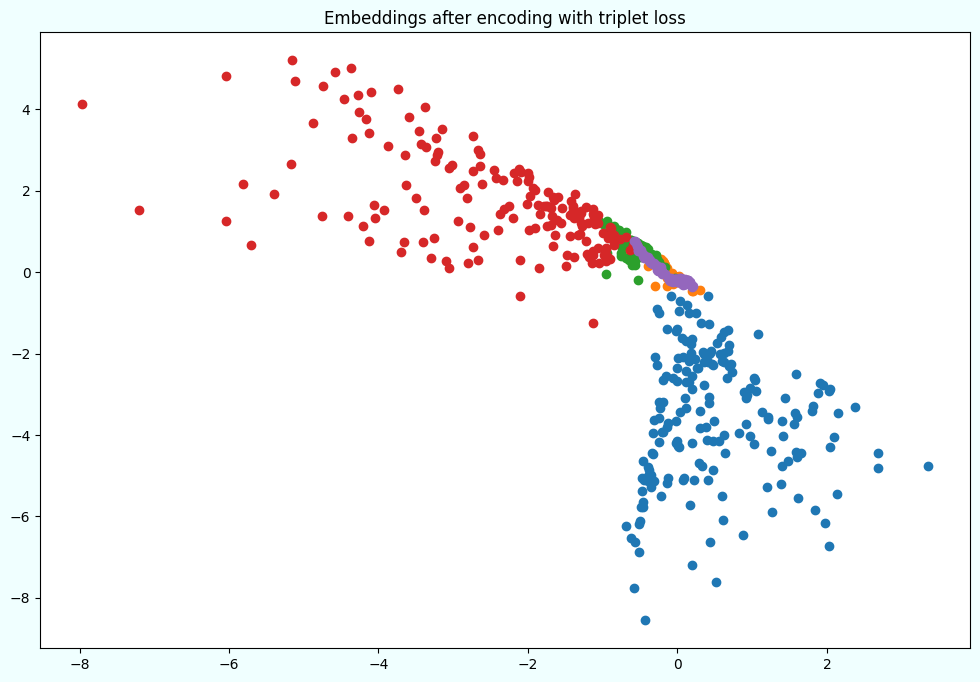

In [14]:
plt.figure(figsize=(12, 8), facecolor="azure")
for label in np.unique(labels):
    tmp = train_results[labels==label]
    plt.scatter(tmp[:, 0], tmp[:, 1])
plt.title("Embeddings after encoding with triplet loss")